# Predicting HDB Resale Prices (2012 - 2021) with Machine Learning (DAB07)

## Introduction

When buying or selling an HDB flat, many rely on platforms like PropertyGuru or 99.co, which focus mainly on flat type, size, and floor level. While useful, they often overlook broader economic trends and neighborhood dynamics that also affect resale values, leading to suboptimal price guidance. How can we provide more accurate pricing by incorporating these currently overlooked factors?

This analysis aims to identify the most effective machine learning model—and the most informative features—for predicting HDB resale prices from 2012 to 2021. Our workflow covers environment setup, feature engineering, feature selection, preprocessing, and the training of multiple models. The goal is to build a robust, accurate predictor of resale prices that clarifies key price drivers and supports better decisions in the HDB resale market.


## 1. Install and Import Libraries

In this section, we will install and import the required libraries needed for data manipulation, visualization, and modeling.

In [63]:
# uncomment to install libraries

#!pip install pandas numpy matplotlib scikit-learn catboost

In [64]:
# import python packages needed for loading data and machine learning

import pandas as pd 
import numpy as np
import sklearn
import lightgbm as lgb
import catboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor


## 2. Model Pre-processing
In this section, we will walk through the essential steps required to prepare our dataset for modeling. The following sections will pre-process the data, and create the train-test split for machine learning.

In [ ]:
# Load data from CSV file to Pandas DataFrame object
df = pd.read_csv('final_data.csv')

### 2.1. Data Pre-processing

In [ ]:
# --- 1) Basic checks & initial shape ---
print('raw data shape:', df.shape)

# --- 2) Make target numeric (invalid entries → NaN) ---
# Keep only rows where target can be parsed as a number; impute features later in your pipeline.
y = pd.to_numeric(df['resale_price'], errors='coerce')

# --- 3) Split features from target ---
X = df.drop(columns=['resale_price'])

# --- 4) Identify column types (encoding/imputation will be handled in the pipeline) ---
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print('numeric cols:', len(numeric_cols), 'categorical cols:', len(cat_cols))

# --- 5) Drop rows with missing target only (do NOT drop feature NaNs; pipeline will impute) ---
mask = ~y.isna()
X = X.loc[mask, numeric_cols].copy()
y = y.loc[mask].copy()

print('after dropping NA target:', X.shape, y.shape)

raw data shape: (150631, 20)
numeric cols: 19 categorical cols: 0
after dropping NA target: (150631, 19) (150631,)


### 2.2. Create Train-Test Split
Splitting the dataset into training and testing sets is essential to evaluate our model's performance on unseen data. We will use train-test split to split our dataset into 75% data for training and 25% data for testing.

In [ ]:
# --- 1) Standard random train/test split (75/25) ---
# Keeps evaluation honest by holding out an unseen test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=123)
print('train:', X_train.shape, y_train.shape)
print('test :', X_test.shape, y_test.shape)

train: (112973, 19) (112973,)
test : (37658, 19) (37658,)


## 3. Modelling

In this section, we will dive into building and evaluating the ML models. The use of ML models enables computers to learn from the dataset and make predictions by identifying patterns in the dataset.

We will build and evaluate 4 ML models:

**1) Random Forest Regressor**<br>
**2) Extra Trees Regressor**<br>
**3) CatBoost Regressor**<br>
**4) LightGBM**

We will use the R-squared and RMSE of the Linear Regression model as baseline metrics to evaluate the performance of our Random Forest, Extra Trees, CatBoost and LightGBM models. These baselines will help us determine if our models are performing well or if further optimization is needed. By the end of this section, we aim to build models that meet or exceed the baselines of the Linear Regression model, ensuring robust and reliable predictions.

After each model has been built, we will examine the feature importance to determine which features have the most significant impact on our model's predictions.

### 3.1. Build the Random Forest Regressor Model
Random Forest is an ensemble machine learning algorithm that constructs a "forest" of multiple decision trees during training and outputs the mode of the classes (for classification) or mean prediction (for regression) of the individual trees. This approach leverages the "wisdom of crowds" to improve predictive accuracy and reduce overfitting compared to a single decision tree.

- **Speed**: Train: Medium, Predict: Fast
- **Accuracy**: High (often very competitive with minimal tuning)

In [ ]:
# --- 1) Configure the model ---
# n_estimators: number of trees (↑ = more stable, slower)
# max_features: fraction of features considered per split (0.5 helps de-correlate trees)
# n_jobs: use all CPU cores
# random_state: reproducibility
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_features=0.5)

# --- 2) Train on the training set only ---
model.fit(X_train, y_train)

# --- 3) Predict on both train and test to check fit/overfit ---
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# --- 4) Evaluate with standard regression metrics ---
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print(f'Train R² : {train_r2:.4f}    Train RMSE : {train_rmse:.4f}')
print(f'Test  R² : {test_r2:.4f}    Test  RMSE : {test_rmse:.4f}')

Train R² : 0.9952    Train RMSE : 9963.9459
Test  R² : 0.9658    Test  RMSE : 26372.5784


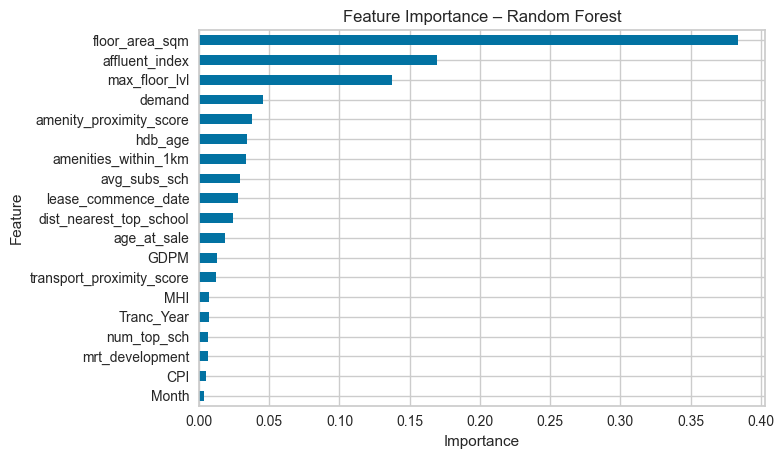

In [ ]:
# --- 1) Build feature names from training columns; fall back to f0, f1, ... if absent ---
feature_names = getattr(X_train, "columns", [f"f{i}" for i in range(X_train.shape[1])])

# --- 2) Build and clean importance series ---
feat_importances = pd.Series(model.feature_importances_, index=feature_names)

# --- 3) Sort so the largest features appear at the TOP of the barh plot ---
# Ascending=True + barh => smallest at bottom, largest at top (nice for reading)
feat_importances = feat_importances.sort_values(ascending=True)

# Keep only top-N most important features (to keep the plot readable)
top_n = min(30, len(feat_importances))  # change 30 to show more/less
to_plot = feat_importances.tail(top_n)

# --- 4) Plot ---
plt.figure(figsize=(8, max(4, top_n * 0.25)))
to_plot.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance – Random Forest')
plt.tight_layout()
plt.show()

### 3.2. Build the Extra Trees Regressor Model
Extra Trees (Extremely Randomized Trees) is an ensemble machine learning model that combines multiple decision trees, similar to Random Forest but with additional randomization. While both use multiple trees, Extra Trees generates splits totally randomly, without searching for optimal thresholds.

- **Speed**: Train: Fast (fewer split searches), Predict: Fast
- **Accuracy**: High (sometimes slightly below Random Forest; sometimes equal—dataset dependent)

In [ ]:
# --- 1) Configure the model ---
# n_estimators: number of trees (↑ → more stable, slower)
# max_features: fraction of features tried at each split (lower → more de-correlated trees)
# n_jobs: use all CPU cores; random_state: reproducibility
model = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# --- 2) Fit on training data only ---
model.fit(X_train, y_train)

# --- 3) Predict on train & test to assess fit / overfit ---
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# --- 4) Evaluate with standard metrics ---
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print(f'Train R² : {train_r2:.4f}    Train RMSE : {train_rmse:.4f}')
print(f'Test  R² : {test_r2:.4f}    Test  RMSE : {test_rmse:.4f}')

Train R² : 1.0000    Train RMSE : 65.6721
Test  R² : 0.9667    Test  RMSE : 26047.7768


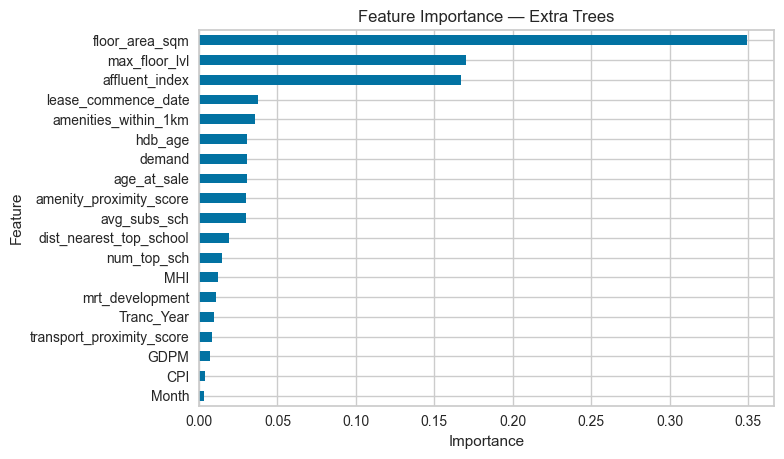

In [ ]:
# --- 1) Resolve feature names robustly ---
# Use DataFrame column names if available; otherwise fall back to f0, f1, ...
feature_names = getattr(X_train, "columns", [f"f{i}" for i in range(X_train.shape[1])])

# --- 2) Build a clean importance Series ---
importances = pd.Series(model.feature_importances_, index=feature_names)

# --- 3) Select top-N and sort so biggest bars appear at the TOP of the barh plot ---
top_n = min(30, importances.size)
to_plot = importances.nlargest(top_n).sort_values(ascending=True)

# --- 4) Plot ---
plt.figure(figsize=(8, max(4, top_n * 0.25)))
to_plot.plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance — Extra Trees")
plt.tight_layout()
plt.show()


### 3.3. Build the Cat Boost Regressor Model
CatBoost is a supervised machine learning method that is used by the Train Using AutoML tool and uses decision trees for classification and regression. As its name suggests, CatBoost has two main features, it works with categorical data (the Cat) and it uses gradient boosting (the Boost).

- **Speed**: Train: Medium → Slow on CPU; Fast with GPU, Predict: Fast
- **Accuracy**: Very high (often state-of-the-art on tabular data)

In [78]:
# --- 1) Configure the model ---
# iterations: upper bound; early stopping will usually halt earlier
model = CatBoostRegressor(iterations=10000, random_seed=42, thread_count=-1)

# --- 2) Fit with early stopping on the validation set ---
model.fit(X_train, y_train)

# --- 3) Predict on train & test to assess fit / overfit ---
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# --- 4) Evaluate with standard metrics ---
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print(f'Train R² : {train_r2:.4f}    Train RMSE : {train_rmse:.4f}')
print(f'Test  R² : {test_r2:.4f}    Test  RMSE : {test_rmse:.4f}')

Learning rate set to 0.013291
0:	learn: 142170.3259941	total: 29.2ms	remaining: 4m 51s
1:	learn: 140886.0784263	total: 39ms	remaining: 3m 14s
2:	learn: 139609.1364728	total: 44ms	remaining: 2m 26s
3:	learn: 138362.7339536	total: 51.4ms	remaining: 2m 8s
4:	learn: 137122.2036624	total: 59.8ms	remaining: 1m 59s
5:	learn: 135909.1969265	total: 67.1ms	remaining: 1m 51s
6:	learn: 134700.9175385	total: 72ms	remaining: 1m 42s
7:	learn: 133537.5745937	total: 77.5ms	remaining: 1m 36s
8:	learn: 132404.9492266	total: 83.8ms	remaining: 1m 32s
9:	learn: 131253.3571469	total: 88.5ms	remaining: 1m 28s
10:	learn: 130129.5588562	total: 93.4ms	remaining: 1m 24s
11:	learn: 129055.4403522	total: 99.1ms	remaining: 1m 22s
12:	learn: 127983.4613125	total: 104ms	remaining: 1m 19s
13:	learn: 126896.0682970	total: 109ms	remaining: 1m 17s
14:	learn: 125835.3205442	total: 115ms	remaining: 1m 16s
15:	learn: 124796.2131450	total: 122ms	remaining: 1m 16s
16:	learn: 123756.0562332	total: 126ms	remaining: 1m 14s
17:	le

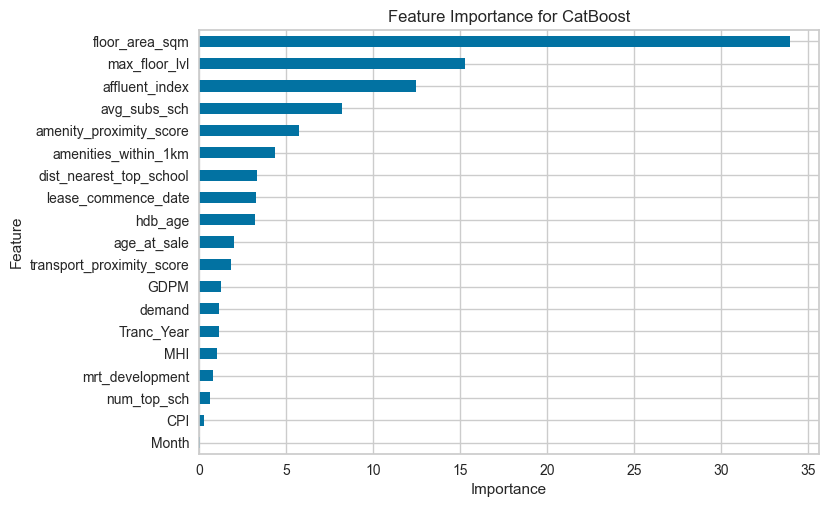

In [ ]:
# --- 1) Build a clean importance Series ---
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')
# --- 2) Plot ---
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for CatBoost')
plt.show()

### 3.4. Build the LightGBM Model
LightGBM is an open-source high-performance framework developed by Microsoft. It is an ensemble learning framework that uses gradient boosting method which constructs a strong learner by sequentially adding weak learners in a gradient descent manner. It's designed for efficiency, scalability and high accuracy particularly with large datasets. It uses decision trees that grow efficiently by minimizing memory usage and optimizing training time. Key innovations like Gradient-based One-Side Sampling (GOSS), histogram-based algorithms and leaf-wise tree growth enable LightGBM to outperform other frameworks in both speed and accuracy.

- **Speed**: Train: Very fast,  Predict: Fast
- **Accuracy**: Very high (top performer with moderate tuning)

In [ ]:
# --- 1) Configure the model ---
# Large n_estimators with early stopping lets the booster find a good iteration.
model = lgb.LGBMRegressor(n_estimators=10000, random_state=42, n_jobs=-1)

# --- 2) Fit with early stopping on the validation set ---
model.fit(X_train, y_train)

# --- 3) Predict on train & test to assess fit / overfit ---
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# --- 4) Evaluate with standard metrics ---
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print(f'Train R² : {train_r2:.4f}    Train RMSE : {train_rmse:.4f}')
print(f'Test  R² : {test_r2:.4f}    Test  RMSE : {test_rmse:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1694
[LightGBM] [Info] Number of data points in the train set: 112973, number of used features: 19
[LightGBM] [Info] Start training from score 449537.540226
Train R² : 0.9961    Train RMSE : 8913.5058
Test  R² : 0.9702    Test  RMSE : 24622.8271


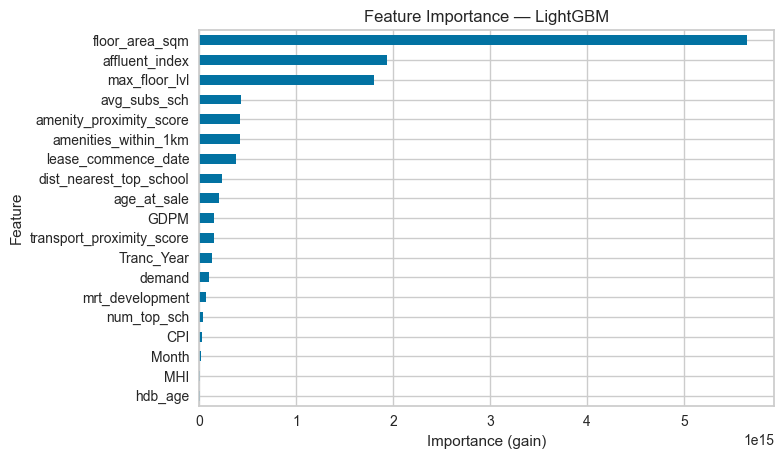

In [ ]:
# --- Feature names (robust) ---
feature_names = getattr(X_train, "columns", None)
if feature_names is None:
    try:
        feature_names = model.booster_.feature_name()
    except Exception:
        feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# --- Importances ---
# 1) Split count (sklearn attribute)
split_imp = pd.Series(model.feature_importances_, index=feature_names)

# 2) Gain (more informative; from the booster)
try:
    gain_imp = pd.Series(
        model.booster_.feature_importance(importance_type="gain"),
        index=feature_names
    )
except Exception:
    gain_imp = None

# Choose what to plot: prefer gain if available & non-zero
imp = gain_imp if (gain_imp is not None and gain_imp.sum() > 0) else split_imp
imp = imp.replace([np.inf, -np.inf], np.nan).fillna(0)

# --- Plot top N as horizontal bars ---
top_n = min(30, imp.size)  # adjust to taste
to_plot = imp.nlargest(top_n).sort_values(ascending=True)

plt.figure(figsize=(8, max(4, top_n * 0.25)))
to_plot.plot(kind="barh")
xlabel = "Importance (gain)" if (gain_imp is not None and gain_imp.sum() > 0) else "Importance (split count)"
plt.xlabel(xlabel)
plt.ylabel("Feature")
plt.title("Feature Importance — LightGBM")
plt.tight_layout()
plt.show()

## 4. Conclusion and Recommendations

We benchmarked multiple machine-learning models to predict Singapore HDB resale prices and evaluated them on train/test R², RMSE, runtime, and the gap between train and test performance. **LightGBM** emerged as the preferred model. As shown in the summary table, it delivers high train and test R² with low RMSE at a reasonable runtime, shows no material overfitting, and exceeds our baselines (≥0.93 R² and RMSE < 37,750).

The following table summarizes the performance of the models we evaluated:

<img src="chart.png" alt="chart" >

Key price drivers identified across models:
- **Affluent Index**
- **Max Floor Lvl**
- **Avg Sub Schs**
- **Amenity Approximity Score**
- **Amenities within 1km**
- **Lease Commence Dates**

This workbook pinpoints and quantifies the attributes that most strongly influence Singapore’s HDB resale prices, offering a clear view of market drivers. Built on a machine-learning model trained on historical transactions, it estimates fair values for specific flats and highlights the incremental impact of key features.

The outputs serve multiple stakeholders:
- **Buyers: benchmark asking prices and assess investment potential.**

- **Sellers: set competitive, realistic listings by understanding value levers.**

- **Agents: deliver data-backed recommendations, track market conditions, and identify opportunities.**

Together, these insights provide a rigorous, transparent, and repeatable framework for navigating the HDB resale market with confidence.

Key references include:
* [Scikit-learn](https://scikit-learn.org/)
* [Random Forest Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* [Extra Trees Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
* [CatBoost Documentation](https://catboost.ai/)
* [LightGBM Documentation](https://lightgbm.readthedocs.io/en/stable/)
* [Stack Overflow](https://stackoverflow.com/)